In [1]:
import networkx as nx
from ipysigma import Sigma
from utils import load_graph
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nx_parallel as nxp

In [3]:
from utils import load_graph_v2
test = load_graph_v2("spotify_graph_l0renzz_5_new_method_scraped3880something.jsonl")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [27]:
# Load the data

G = load_graph("spotify_graph_l0renzz_5.jsonl")
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 567493, Edges: 2107651


with old method: Nodes: 67124, Edges: 110123

In [4]:
node = next(iter(G.nodes))
print(f"Node ID: {node}")
print(f"Attributes: {G.nodes[node]}")
data = pd.Series([data if data is not None else 0 for node, data in G.nodes(data='followers_count')])
data_capped = data.clip(upper=1000)

Node ID: l0renzz
Attributes: {'name': 'lorenzo', 'followers_count': 43}


<Axes: ylabel='Count'>

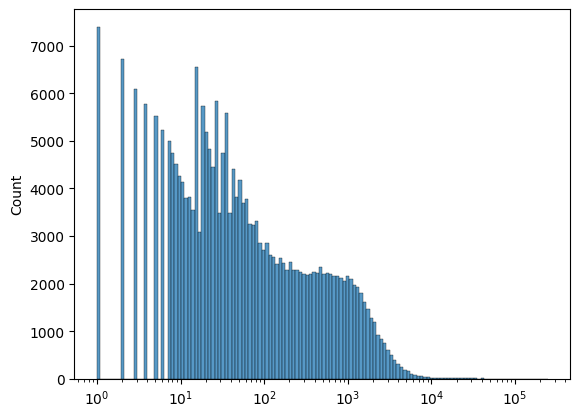

In [31]:
sns.histplot(data, log_scale=True)

In [7]:

G_undirected = G.to_undirected()
# --- Basic Counts ---
num_nodes = G.number_of_nodes()       # |V|
num_edges = G.number_of_edges()       # |E|

# --- Degree Metrics ---
degrees = [d for n, d in G.degree()]
d_max = max(degrees)                  # d_max
d_avg = np.mean(degrees)              # d_avg (or 2 * num_edges / num_nodes)

# --- Assortativity ---
# r: Measures if high-degree nodes connect to other high-degree nodes
assortativity = nx.degree_assortativity_coefficient(G_undirected)

# --- Triangle Metrics (Node Based) ---
# nx.triangles(G) returns a dict of {node: count}. 
# Summing them counts every triangle 3 times (once for each node in the triangle).
total_triangles = sum(nx.triangles(G_undirected).values()) / 3  # |T|

# --- Triangle Metrics (Edge Based) ---
# NetworkX doesn't have a direct "triangles per edge" function, 
# so we calculate it by finding common neighbors for every edge.
triangles_per_edge = []
for u, v in G_undirected.edges():
    # The number of triangles an edge (u,v) is part of 
    # equals the number of neighbors u and v share.
    common = len(list(nx.common_neighbors(G_undirected, u, v)))
    triangles_per_edge.append(common)

if triangles_per_edge:
    t_avg_edge = np.mean(triangles_per_edge)  # |T|_avg
    t_max_edge = np.max(triangles_per_edge)   # |T|_max
else:
    t_avg_edge = 0
    t_max_edge = 0

# --- Clustering Coefficients ---
# κ_avg: Average of the local clustering coefficients
avg_local_clustering = nx.average_clustering(G_undirected)

# κ: Global clustering coefficient (also known as Transitivity)
# Ratio of 3 * triangles to all possible triplets
global_clustering = nx.transitivity(G_undirected)
# --- K-Core ---
# K_max: The largest k for which a k-core exists
# Core number is the largest k-core a node belongs to.
# core_numbers = nx.core_number(G_undirected)
# k_max = max(core_numbers.values())

# --- Clique Size (Lower Bound) ---
# ω_lb: Finding the EXACT max clique is NP-Hard.
# We use an approximation heuristic to find a large clique quickly.
# The size of this clique is a valid lower bound.
# max_clique_approx = nx.approximation.max_clique(G_undirected)
# omega_lb = len(max_clique_approx)

# --- Printing Results ---
print(f"|V| (Nodes): {num_nodes}")
print(f"|E| (Edges): {num_edges}")
print(f"d_max (Max Degree): {d_max}")
print(f"d_avg (Avg Degree): {d_avg:.2f}")
print(f"r (Assortativity): {assortativity:.4f}")
print(f"|T| (Total Triangles): {int(total_triangles)}")
print(f"|T|_avg (Avg Triangles/Edge): {t_avg_edge:.2f}")
print(f"|T|_max (Max Triangles/Edge): {t_max_edge}")
print(f"κ_avg (Avg Local Clustering): {avg_local_clustering:.4f}")
print(f"κ (Global Clustering): {global_clustering:.4f}")
# print(f"K_max (Max k-core): {k_max}")
print(f"ω_lb (Max Clique Lower Bound): {omega_lb}")

|V| (Nodes): 242331
|E| (Edges): 1060440
d_max (Max Degree): 2481
d_avg (Avg Degree): 8.75
r (Assortativity): -0.5200
|T| (Total Triangles): 6213382
|T|_avg (Avg Triangles/Edge): 17.79
|T|_max (Max Triangles/Edge): 1213
κ_avg (Avg Local Clustering): 0.0706
κ (Global Clustering): 0.0343


NameError: name 'omega_lb' is not defined

In [20]:
min_degree = 1000
core = G.subgraph([n for n in G.nodes if G.degree(n) >= min_degree]).copy()
print(f"Core graph: {core.number_of_nodes()} nodes, {core.number_of_edges()} edges")

Core graph: 766 nodes, 47891 edges


In [21]:
Sigma(core, node_label="name", node_size=core.degree, default_edge_type="curve", start_layout=5)

Sigma(nx.DiGraph with 766 nodes and 47,891 edges)

# Calculating base measures

## Degree

In [33]:
degrees = [d for n, d in G.degree()]
d_max = max(degrees)                  # d_max
d_avg = np.mean(degrees)
print(d_avg, d_max)

7.427936556045625 4691


## Clustering

In [26]:
avg_local_clustering = nx.average_clustering(G_undirected)
global_clustering = nx.transitivity(G_undirected)
print("Average Local Clustering Coeff: ", avg_local_clustering)
print("Global Clustering Coeff: ", global_clustering)

Average Local Clustering Coeff:  0.070617074138192
Global Clustering Coeff:  0.0342520118930286


## Density

In [16]:
density = nx.density(G)
print(f"Density: {density:.6f}")

Density: 0.000018


## Transitivity

In [17]:
transitivity = nxp.betweenness_centrality(G)
print(f"Transitivity: {transitivity:.6f}")

Transitivity: 0.088134


## Centrality

In [25]:
betweeness_centrality = nx.betweenness_centrality(G)
#closeness_centrality = nx.closeness_centrality(G)
print("Computed betweenness and closeness centrality:")
print(betweeness_centrality)

KeyboardInterrupt: 

In [38]:
# Set the backend to parallel for this computation
nx.set_backend("parallel")

# If successful, NetworkX may log the dispatching event depending on your log level
# For a directed graph, we should use weakly_connected_components
result = nx.weakly_connected_components(G)
print(f"Number of weakly connected components: {len(list(result))}")

# It's good practice to reset the backend to default if you don't need it for subsequent cells
nx.set_backend("sequential")

AttributeError: module 'networkx' has no attribute 'set_backend'

In [12]:
# Skip those nodes who presumably don't follow anyone
G_without_users_who_are_not_followed = G.subgraph([n for n in G.nodes if G.in_degree(n) > 0]).copy()
reciprocity = nx.reciprocity(G_without_users_who_are_not_followed)
print(f"Reciprocity: {reciprocity:.4f}")

Reciprocity: 0.2439
